<a href="https://colab.research.google.com/github/Harsha-Chinthala/Bidirectional-LSTM-GRU-Model/blob/main/Hybrid_Sentiment_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LSTM Bidirectional GRU**

### Kaggle Dataset Extraction

In [ ]:
#installing kaggle to import the dataset....directly
!pip install kaggle


In [ ]:
#Importing Kaggle.json file...
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chvk18","key":"80fe738af119547100acf1b6e44eef01"}'}

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/


In [ ]:
#changing the permission to kaggle file
!chmod 600 ~/.kaggle/kaggle.json

### Downloading the dataset from Kaggle Site

In [ ]:
!kaggle datasets download -d bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 99% 488M/493M [00:05<00:00, 137MB/s]
100% 493M/493M [00:05<00:00, 103MB/s]


In [ ]:
! unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


Importing the modules

In [ ]:
import bz2
import os
import pandas as pd
import string
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
os.listdir('/content/')

['.config',
 'kaggle.json',
 'train.ft.txt.bz2',
 'test.ft.txt.bz2',
 'amazonreviews.zip',
 'sample_data']

### Reading the Dataset

In [ ]:
trainfile = bz2.BZ2File('/content/train.ft.txt.bz2','r')
testfile = bz2.BZ2File('/content/test.ft.txt.bz2','r')
lines = trainfile.readlines()
lines[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [ ]:
len(lines)

3600000

In [ ]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        text=str(lines[i])
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [ ]:
docSentimentList=getDocumentSentimentList(lines[:1000000],splitStr='__label__')

Done!!


In [ ]:
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


In [ ]:
train_df.describe()

,Text,Sentiment
count,1000000,1000000
unique,1000000,2
top,Stuning even for the non-gamer: This sound tra...,2
freq,1,505678


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [ ]:
train_df.groupby('Sentiment').describe()

Text                                                             \
            count  unique                                                top   
Sentiment                                                                      
1          494322  494322  Buyer beware: This is a self-published book, a...   
2          505678  505678  Stuning even for the non-gamer: This sound tra...   

                
          freq  
Sentiment       
1            1  
2            1

In [ ]:
train_df['length'] = train_df['Text'].apply(len)
train_df.head()
train_df.iloc[:1]

,Text,Sentiment,length
0,Stuning even for the non-gamer: This sound tra...,2,428


### Data Visualization
Let's visualize this! Let's do the imports:

<Axes: xlabel='Sentiment', ylabel='count'>

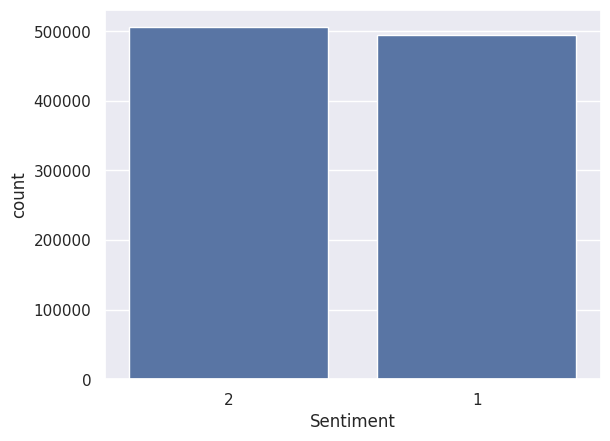

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="Sentiment", data=train_df)

<Axes: ylabel='Frequency'>

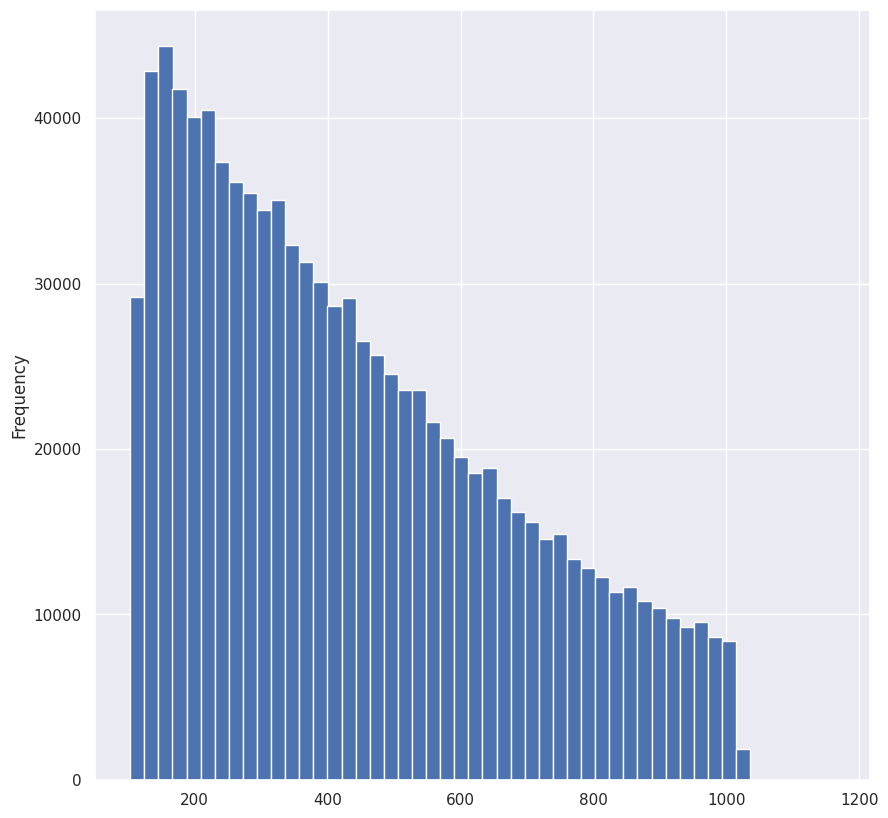

In [ ]:
import seaborn as sns
train_df['length'].plot(bins=50, kind='hist',figsize = (10,10))

In [ ]:
train_df.length.describe()

,length
count,1000000.000000
mean,439.482006
std,239.716708
min,103.000000
25%,237.000000
50%,392.000000
75%,607.000000
max,1163.000000


array([<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>],
      dtype=object)

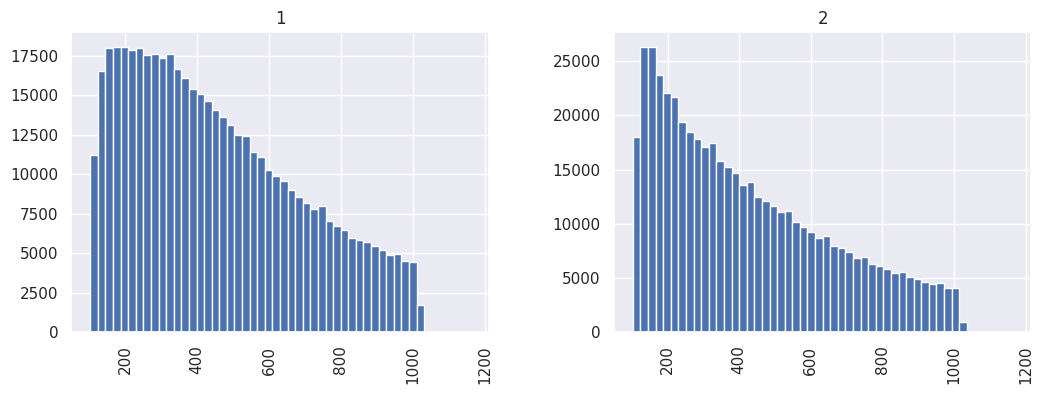

In [ ]:
train_df.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

### Data PreProcessing

In [ ]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

<ipython-input-22-db5e223bef04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
<ipython-input-22-db5e223bef04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Sentiment'][train_df['Sentiment']=='2'] = 1


In [ ]:
train_df['Sentiment'].value_counts()

,count
Sentiment,
1,505678
0,494322


In [ ]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,length,word_count
0,Stuning even for the non-gamer: This sound tra...,1,428,80
1,The best soundtrack ever to anything.: I'm rea...,1,511,97
2,Amazing!: This soundtrack is my favorite music...,1,768,129
3,Excellent Soundtrack: I truly like this soundt...,1,745,118
4,"Remember, Pull Your Jaw Off The Floor After He...",1,483,87


In [ ]:
import string
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)

In [ ]:
train_df['Text'] = train_df['Text'].apply(remove_punc)
train_df.shape

(1000000, 4)

In [ ]:
train_df.head()

,Text,Sentiment,length,word_count
0,Stuning even for the nongamer This sound track...,1,428,80
1,The best soundtrack ever to anything Im readin...,1,511,97
2,Amazing This soundtrack is my favorite music o...,1,768,129
3,Excellent Soundtrack I truly like this soundtr...,1,745,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,483,87


In [ ]:
len(train_df['word_count'][train_df['word_count']<=25])

63720

In [ ]:
train_df1 = train_df[:][train_df['word_count']<=25]
train_df1.head()

,Text,Sentiment,length,word_count
44,autumn got this for my daughter in NC she is n...,1,112,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,121,25
77,Smells divine This is my second bottle of shee...,1,145,25
78,Very disappointed This perfume is just AWFUL S...,0,155,24
99,Caution These tracks are not the original vers...,0,148,22


In [ ]:
train_df1.head()

,Text,Sentiment,length,word_count
44,autumn got this for my daughter in NC she is n...,1,112,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,121,25
77,Smells divine This is my second bottle of shee...,1,145,25
78,Very disappointed This perfume is just AWFUL S...,0,155,24
99,Caution These tracks are not the original vers...,0,148,22


In [ ]:
train_df1['Sentiment'].value_counts()

,count
Sentiment,
1,39932
0,23788


In [ ]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = list(st_wd),min_df=.0001,lowercase=True)
c_vector.fit(train_df1['Text'].values)

CountVectorizer(min_df=0.0001,
                stop_words=['etc', 'wherein', 'may', 'becomes', 'however',
                            'last', 'next', 'nor', 'perhaps', 'except', 'take',
                            'thereafter', 'there', 'twenty', 'ten', 'that',
                            'else', 'ltd', 'off', 'hence', 'an', 'thereupon',
                            'myself', 'part', 'us', 'other', 'elsewhere',
                            'mill', 'via', 'above', ...])

In [ ]:
word_list = list(c_vector.vocabulary_.keys())
stop_words = list(c_vector.stop_words)

In [ ]:
len(stop_words),len(word_list)

(318, 8915)

In [ ]:
def remove_words(raw_sen,stop_words):
    sen = [w for w in raw_sen if w not in stop_words]
    return sen

In [ ]:
def reviewEdit(raw_sen_list,stop_words):
    sen_list = []
    for i in range(len(raw_sen_list)):
        raw_sen = raw_sen_list[i].split()
        sen_list.append(remove_words(raw_sen,stop_words))
    return sen_list

In [ ]:
sen_list = reviewEdit(list(train_df1['Text']),stop_words)

### Word2Vec Creation

In [ ]:
from gensim.models import word2vec
wv_model = word2vec.Word2Vec(sen_list,vector_size=100)

In [ ]:
wv_model.wv.vectors.shape

(14350, 100)

In [ ]:
wv_model.wv.most_similar("car")

[('pair', 0.9227299094200134),
 ('cream', 0.9133795499801636),
 ('pants', 0.9065651297569275),
 ('lights', 0.9048165082931519),
 ('cards', 0.904382586479187),
 ('bottle', 0.9041347503662109),
 ('ball', 0.9026737809181213),
 ('heads', 0.9016111493110657),
 ('jeans', 0.8987959623336792),
 ('machine', 0.8971662521362305)]

In [ ]:
import numpy as np
def fun(sen_list,wv_model):
    word_set = set(wv_model.wv.index_to_key)
    X = np.zeros([len(sen_list),25,100])
    c = 0
    for sen in sen_list:
        nw=24
        for w in list(reversed(sen)):
            if w in word_set:
                X[c,nw] = wv_model.wv[w]
                nw=nw-1
        c=c+1
    return X

In [ ]:
X = fun(sen_list,wv_model)

In [ ]:
from sklearn.model_selection import train_test_split
y = train_df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(57348, 25, 100)

### Model Building - Bidirectional LSTM GRU

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Activation, Bidirectional, GRU, Input, Multiply, Reshape, Layer

# Define a custom layer for summing along a specific axis
class SumAlongAxis(Layer):
    def call(self, inputs):
        return tf.reduce_sum(inputs, axis=1)

# Input Layer
input_st = Input(shape=(25, 100))

# Bidirectional GRU Layers
lstm1 = Bidirectional(GRU(200, activation='relu', return_sequences=True), merge_mode='mul')(input_st)
lstm2 = Bidirectional(GRU(1, activation='relu', return_sequences=True), merge_mode='mul')(lstm1)

print(lstm1.shape, ' ', lstm2.shape)

# Reshape and Activation
lstm2 = Reshape((-1,))(lstm2)
lstm2 = Activation('sigmoid')(lstm2)
lstm2 = Reshape((-1, 1))(lstm2)

# Element-wise Multiplication
mult = Multiply()([lstm1, lstm2])

# Use the custom SumAlongAxis layer instead of Lambda
add = SumAlongAxis()(mult)

# Dense Layers
dense = Dense(100, activation='relu')(add)
output = Dense(1, activation='sigmoid')(dense)

# Create Model
model = Model(inputs=input_st, outputs=output)

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
print(model.summary())

(None, 25, 200)   (None, 25, 1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 25, 100)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 25, 200)        │        362,400 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 25, 1)          │          1,218 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 25)             │              0 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 25)             │              0 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 25, 1)          │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 25, 200)        │              0 │ bidirectional_4[0][0], │
│                           │                        │                │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sum_along_axis            │ (None, 200)            │              0 │ multiply_2[0][0]       │
│ (SumAlongAxis)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 100)            │         20,100 │ sum_along_axis[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            101 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 383,819 (1.46 MB)

 Trainable params: 383,819 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
import numpy as np

# Convert X_train and y_train to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_split=0.1,epochs=10, batch_size=512,callbacks=[early_stop])

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 101s 929ms/step - accuracy: 0.7883 - loss: 0.4141 - val_accuracy: 0.8696 - val_loss: 0.3059
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 141s 930ms/step - accuracy: 0.8797 - loss: 0.2914 - val_accuracy: 0.8732 - val_loss: 0.2957
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 143s 936ms/step - accuracy: 0.8904 - loss: 0.2627 - val_accuracy: 0.8830 - val_loss: 0.2780
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 92s 914ms/step - accuracy: 0.8984 - loss: 0.2465 - val_accuracy: 0.8781 - val_loss: 0.2814
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 146s 950ms/step - accuracy: 0.8969 - loss: 0.2423 - val_accuracy: 0.8891 - val_loss: 0.2665
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 138s 913ms/step - accuracy: 0.9047 - loss: 0.2271 - val_accuracy: 0.8914 - val_loss: 0.2562
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9099 - loss: 0.2156 - val_accuracy: 0.8914 - val_loss: 0.2572
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 122s 931ms/step - accuracy: 0.9166 - los

### Model Evaluation

In [ ]:
import numpy as np

# Convert X_test and y_test to float32
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# model.evaluate(X_test, y_test, batch_size=64)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# Step 1: Define your custom layer with proper logic
@register_keras_serializable()  # This decorator ensures that the custom layer is registered for serialization
class SumAlongAxis(tf.keras.layers.Layer):
    def call(self, inputs):
        # Implement the logic for summing along a specified axis (e.g., axis=1)
        return tf.reduce_sum(inputs, axis=1)

# Step 2: Save the trained model (ensure the model uses the custom layer)
# Assuming 'model' is already trained
model.save('amazon_sentiment_model.keras')
print("Model saved successfully.")

# Step 3: Load the model with the custom layer properly registered
# Ensure to pass 'SumAlongAxis' in custom_objects during loading
loaded_model = load_model('amazon_sentiment_model.keras', custom_objects={'SumAlongAxis': SumAlongAxis})
print("Model loaded successfully.")

# Step 4: Evaluate the loaded model (assuming X_test and y_test are defined and preprocessed)
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Evaluation - Loss: {loss}, Accuracy: {accuracy}")

Model saved successfully.
Model loaded successfully.
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9024 - loss: 0.2499
Evaluation - Loss: 0.2504386603832245, Accuracy: 0.9028562307357788


In [ ]:
scores = model.evaluate(X_test, y_test)
print("Test acc: %.2f%%" % (scores[1]*100))

200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9024 - loss: 0.2499
Test acc: 90.29%


In [ ]:
model.evaluate(X_train, y_train, batch_size=1024)

57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9235 - loss: 0.1880


[0.19537879526615143, 0.9202762246131897]

In [ ]:
scores = model.evaluate(X_train, y_train)
print("Train acc: %.2f%%" % (scores[1]*100))

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 93s 52ms/step - accuracy: 0.9239 - loss: 0.1871
Train acc: 92.03%


### Classification Matrix

In [ ]:
prob_test = model.predict(X_test).reshape((-1,))
pred_test = np.array([1 if y>0.5 else 0 for y in prob_test])
y_test = y_test.astype('int')
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test))

200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2367
           1       0.93      0.92      0.92      4005

    accuracy                           0.90      6372
   macro avg       0.89      0.90      0.90      6372
weighted avg       0.90      0.90      0.90      6372



### Confusion Matrix

<Axes: xlabel='Predicted', ylabel='Actual'>

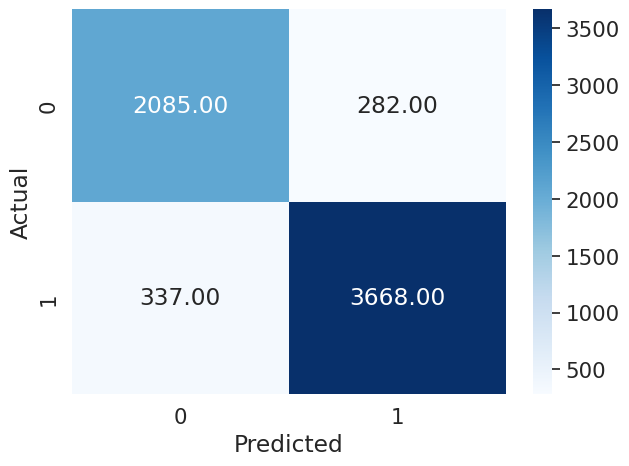

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, pred_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='.2f')

### ROC-AUC and other curves

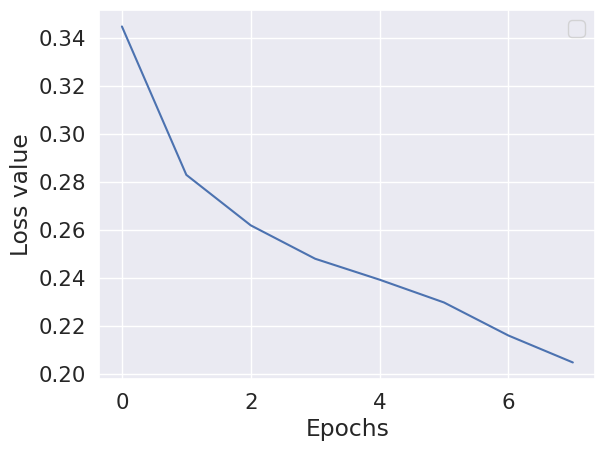

In [ ]:
import matplotlib.pyplot as plt
loss_curve = hist.history['loss']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.plot(epoch_c,loss_curve)
plt.legend()
plt.show()

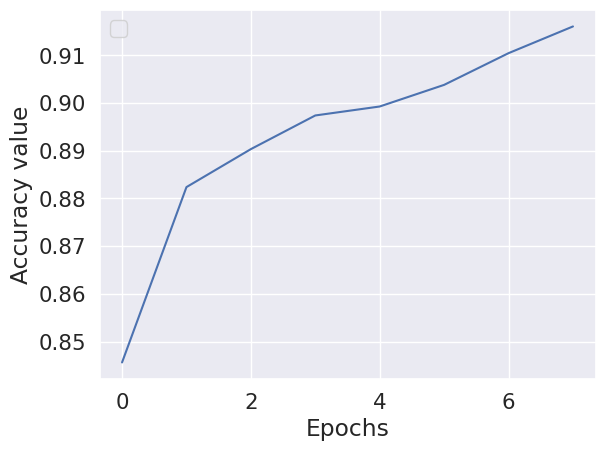

In [ ]:
accuracy_curve = hist.history['accuracy']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.plot(epoch_c,accuracy_curve)
plt.legend()
plt.show()

In [ ]:


from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)



200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

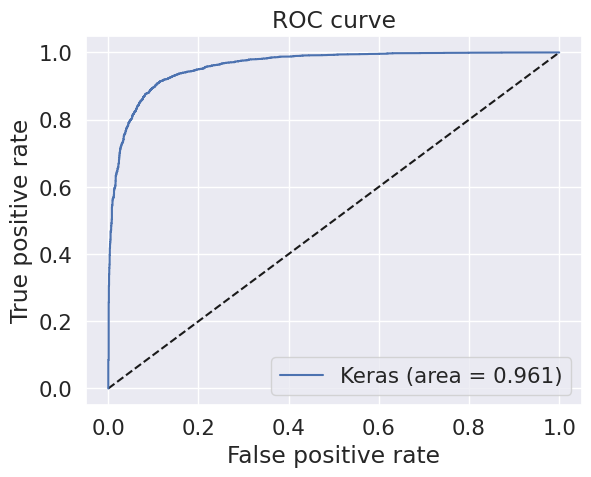

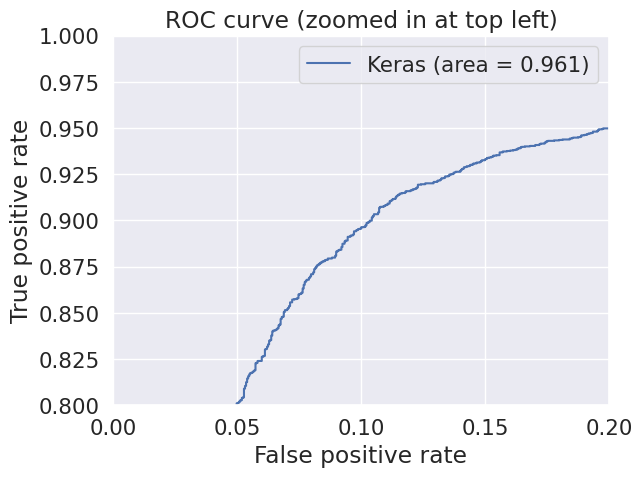

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
def predict_sentiment(comment, wv_model, model):
  # Preprocess the input
  comment = remove_punc(comment)
  comment = remove_words(comment.split(), stop_words)
  word_set = set(wv_model.wv.index_to_key)
  X = np.zeros((1, 25, 100))
  nw = 24
  for w in list(reversed(comment)):
    if w in word_set:
      X[0, nw] = wv_model.wv[w]
      nw -= 1
      if nw < 0: # Check if nw is less than 0
        break # Exit the loop if nw is less than 0 to avoid index error
        # Predict the sentiment
  prediction = model.predict(X)
  return prediction

In [ ]:
train_df.to_csv('traindata.csv')

In [ ]:
train_df

,Text,Sentiment,length,word_count
0,Stuning even for the nongamer This sound track...,1,428,80
1,The best soundtrack ever to anything Im readin...,1,511,97
2,Amazing This soundtrack is my favorite music o...,1,768,129
3,Excellent Soundtrack I truly like this soundtr...,1,745,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,483,87
...,...,...,...,...
999995,Not as good as expected First off let me say t...,1,829,143
999996,Quality lens Very good quality lens feels soli...,1,144,24
999997,Havent used it enough Havent used it enough to...,1,209,39
999998,Canon L Lens at its Best Got this lens with my...,1,457,80


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score

# Assuming you have y_test and pred_test defined

accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
recall = recall_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test)
loss = log_loss(y_test, pred_test)
roc_auc = roc_auc_score(y_test, pred_test)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Loss: {loss}")
print(f"ROC-AUC Score: {roc_auc}")

Accuracy: 0.9028562460765851
Precision: 0.9286075949367089
Recall: 0.9158551810237203
F1-score: 0.9221873035826524
Loss: 3.5014157953332576
ROC-AUC Score: 0.8983585157336599


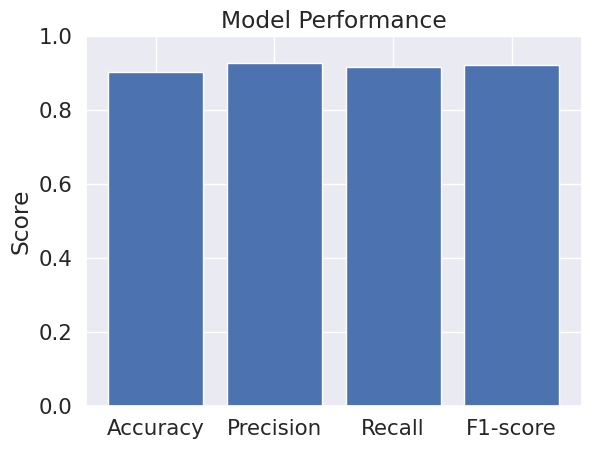

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Calculate the metrics
accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
recall = recall_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test)

# Create a bar plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values)
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.show()

In [ ]:
def chat_bot(wv_model, model):
    print("Hello user, what's your name?")
    name = input()
    print(f'Nice to meet you {name}! Please enter a comment to analyze.')
    while True:
        comment = input()
        prediction = predict_sentiment(comment, wv_model, model)
        if prediction > 0.5:
            print("Positive")
        else:
            print("Negative")
        another_comment = input("Do you want to analyze another comment? (y/n)")
        if another_comment.lower() != 'y':
            print(f"Thank you for chatting, {name}! Have a nice day.")
            break

# Start the chatbot
chat_bot(wv_model, model)

Hello user, what's your name?
HVK
Nice to meet you HVK! Please enter a comment to analyze.
I hate that product
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Negative
Do you want to analyze another comment? (y/n)y
Product not working
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Negative
Do you want to analyze another comment? (y/n)n
Thank you for chatting, HVK! Have a nice day.


In [ ]:
import tensorflow as tf

# Save the entire model
model.save('amazon_sentiment_model.h5')

# Save the Word2Vec model
wv_model.save('word2vec_model.bin')

# Save the stop words
import pickle
with open('stop_words.pkl', 'wb') as f:
    pickle.dump(stop_words, f)

print("Model and associated data saved successfully.")

Model and associated data saved successfully.


In [ ]:
import pkg_resources

# Check the version of a specific package
def get_package_version(package_name):
  try:
    version = pkg_resources.get_distribution(package_name).version
    return f"{package_name}=={version}"
  except pkg_resources.DistributionNotFound:
    return f"{package_name} not found"

# Get versions of a list of packages
packages = ['tensorflow', 'keras', 'scikit-learn', 'pandas', 'nltk', 'gensim']
for package in packages:
  print(get_package_version(package))

tensorflow==2.17.0
keras==3.4.1
scikit-learn==1.5.2
pandas==2.1.4
nltk==3.8.1
gensim==4.3.3


In [ ]:
model = tf.keras.models.load_model('amazon_sentiment_model.h5')